In [2]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import survivors.datasets as ds

import warnings
warnings.filterwarnings("ignore")

In [3]:
# axis_font = {'fontname':'Arial', 'size':'14'}
axis_font = {'fontname':'Times New Roman', 'size':'16'}
sns.set_context(rc={'lines.linewidth':2})

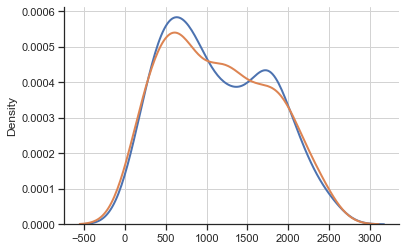

In [4]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

# X, y, features, categ, sch_nan = ds.load_actg_dataset()
X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
# X, y, features, categ, sch_nan = ds.load_wuhan_dataset()

qs = np.quantile(y["time"], np.linspace(0.2, 0.8, 4))
time_discr = np.searchsorted(qs, y["time"])

discr = np.char.add(time_discr.astype(str), y["cens"].astype(str))
X_TR, X_HO = train_test_split(X, stratify=discr, test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

df = X_HO.copy()
df["time"] = y_HO["time"]
df["cens"] = y_HO["cens"]

df_tr = X_tr.copy()
df_tr["time"] = y_tr["time"]
df_tr["cens"] = y_tr["cens"]

sns.kdeplot(y_tr["time"], label="train")
sns.kdeplot(y_HO["time"], label="HO")
plt.show()

<Axes: ylabel='Density'>

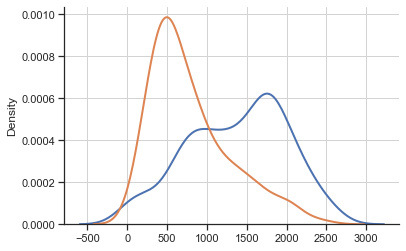

In [120]:
sns.kdeplot(y_tr[np.where(y_tr["cens"] == 0)[0]]["time"], label="train")
sns.kdeplot(y_tr[np.where(y_tr["cens"] == 1)[0]]["time"], label="train")

(0.0, 4000.0)

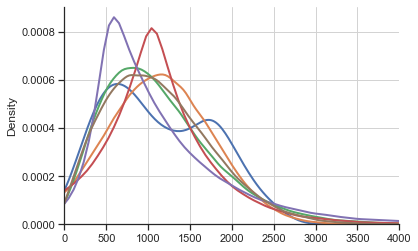

In [119]:
import scipy.stats as stats

sns.kdeplot(y_tr["time"])
for st in [stats.norm, stats.gamma, stats.laplace, stats.laplace_asymmetric, stats.rayleigh]:
    params = st.fit(y_tr["time"])
    sns.kdeplot(st.rvs(*params, size=100000, random_state=42))
plt.xlim((0, 4000))

### Informative censuring comparison

In [23]:
from survivors.external.nonparametric import KaplanMeier

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
bins_HO = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])

df = X.copy()
df["time"] = y["time"]
df["cens"] = y["cens"]

SF IBS:0.19145, AUPRC:0.58663
SF1 IBS:0.18165, AUPRC:0.65868
SF2 IBS:0.17418, AUPRC:0.68050


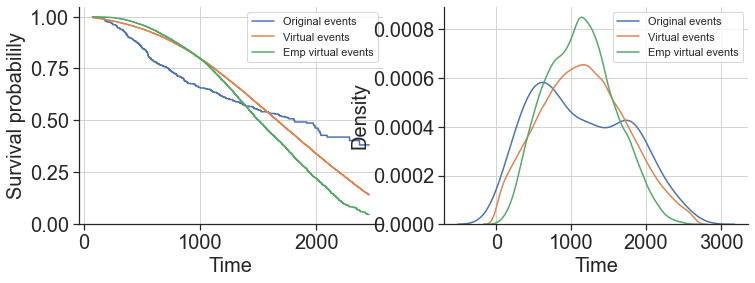

In [179]:
def med_std(x):
    N = len(x)
    d2 = abs(x - np.median(x))**2  # abs is for complex `a`
    var = np.sum(d2) / N  # note use of `ddof`
    return var**0.5

class KaplanMeierZeroAfter(KaplanMeier):
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.array(durations)
        self.events = np.array(right_censor)
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        # place_bin = np.digitize(times, self.timeline)  # -1
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf
    
class KaplanMeierZeroAfterTh(KaplanMeier):
    def __init__(self, d_type, *args, **kwargs):
        self.d_type = d_type
        super().__init__(*args, **kwargs)
        
    def fit(self, durations, right_censor, weights=None):
#         q1, q2 = np.quantile(durations, [0.05, 0.95])
        params = self.d_type.fit(durations)
#         params = self.d_type.fit(durations[right_censor == 1])
#         params = list(params)
#         params[1] = params[1] / np.sqrt(1.5)
        self.durs = self.d_type.rvs(*params, size=100000, random_state=42)
        self.events = np.random.choice(right_censor, size=100000, replace=True)
#         self.durs = np.hstack([durations.copy(), self.durs])
#         self.events = np.hstack([right_censor.copy(), self.events])

        ind = (self.durs >= durations.min()) & (self.durs <= durations.max())
#         ind = (self.durs >= q1) & (self.durs <= q2)
        self.events = self.events[ind]
        self.durs = self.durs[ind]
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf
    
class KaplanMeierZeroAfterEmp(KaplanMeierZeroAfter):
    """
    Nonparametric model with virtual events generated by bootstrap meaning
    """
    def __init__(self, n=2, *args, **kwargs):
        self.n = n
        super().__init__(*args, **kwargs)
        
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.random.choice(durations, size=(self.n, 20000), replace=True).mean(axis=0)
        self.events = np.random.choice(right_censor, size=20000, replace=True)
        
        super().fit(self.durs, self.events)

y_ = y
X_ = X

km = KaplanMeierZeroAfter()
km.fit(y_["time"], y_["cens"])
sf = km.survival_function_at_times(bins_HO)

km1 = KaplanMeierZeroAfterTh(stats.norm)
km1.fit(y_["time"], y_["cens"])
sf1 = km1.survival_function_at_times(bins_HO)

km2 = KaplanMeierZeroAfterEmp(2)
km2.fit(y_["time"], y_["cens"])
sf2 = km2.survival_function_at_times(bins_HO)

ibs_sf = metr.ibs_remain(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
ibs_sf1 = metr.ibs_remain(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
ibs_sf2 = metr.ibs_remain(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO)

auprc_sf = metr.auprc(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
auprc_sf1 = metr.auprc(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
auprc_sf2 = metr.auprc(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].step(bins_HO, sf, label="Original events")
axes[0].step(bins_HO, sf1, label="Virtual events")
axes[0].step(bins_HO, sf2, label="Emp virtual events")
axes[0].legend()

sns.kdeplot(km.durs, ax=axes[1], label="Original events")
sns.kdeplot(km1.durs, ax=axes[1], label="Virtual events")
sns.kdeplot(km2.durs, ax=axes[1], label="Emp virtual events")
axes[1].legend()

axes[0].set_xlabel("Time")
axes[0].set_ylabel("Survival probabilily")
axes[1].set_xlabel("Time")
print(f"SF IBS:{ibs_sf:.5f}, AUPRC:{auprc_sf:.5f}")
print(f"SF1 IBS:{ibs_sf1:.5f}, AUPRC:{auprc_sf1:.5f}")
print(f"SF2 IBS:{ibs_sf2:.5f}, AUPRC:{auprc_sf2:.5f}")

In [158]:
np.quantile(km.durs, np.linspace(0.01, 0.99, 20))

array([   3.        ,    5.        ,    8.        ,   13.        ,
         20.        ,   30.        ,   47.48842105,   76.        ,
        121.        ,  190.        ,  284.78736842,  395.        ,
        483.93684211,  598.        ,  711.        ,  850.66105263,
       1020.        , 1389.81052632, 1670.        , 1984.        ])

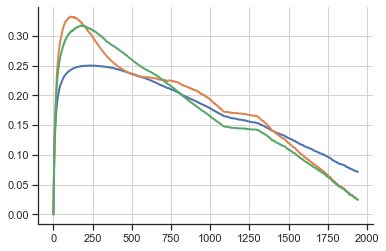

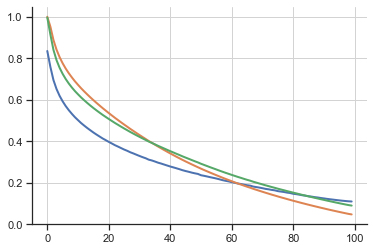

In [150]:
ibs_sf_ = metr.ibs_remain(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
ibs_sf1_ = metr.ibs_remain(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
ibs_sf2_ = metr.ibs_remain(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)

plt.plot(ibs_sf_)
plt.plot(ibs_sf1_)
plt.plot(ibs_sf2_)
plt.show()

auprc_sf_ = metr.auprc(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
auprc_sf1_ = metr.auprc(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
auprc_sf2_ = metr.auprc(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
plt.plot(auprc_sf_)
plt.plot(auprc_sf1_)
plt.plot(auprc_sf2_)
plt.show()

<Axes: >

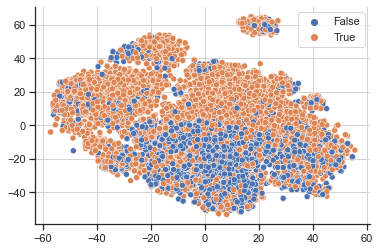

In [159]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X.fillna(X.median()))
X_embedded = TSNE(n_components=2, perplexity=50, learning_rate='auto', random_state=42).fit_transform(X_scaled)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1],
                hue=y["cens"])

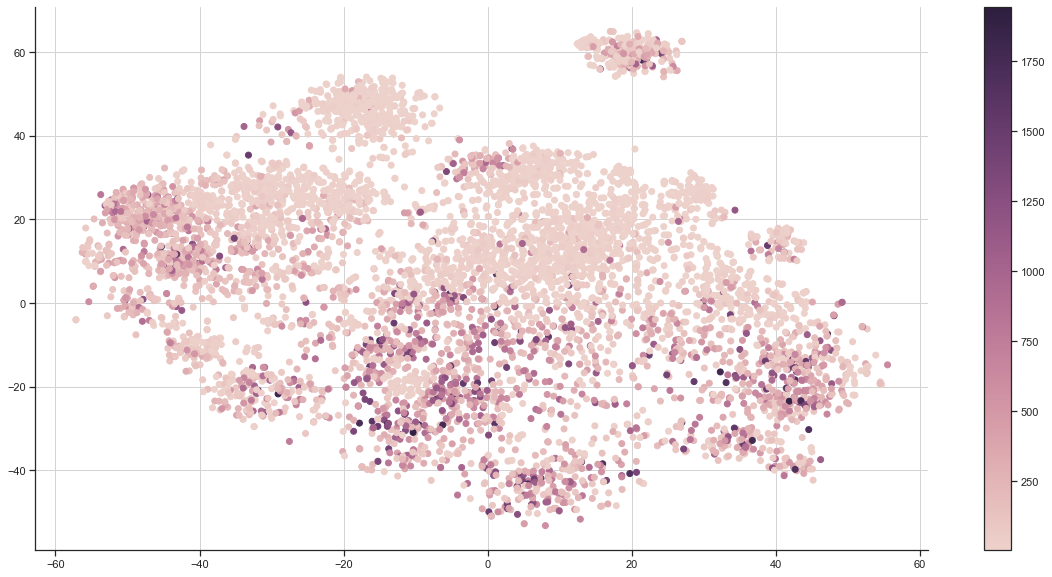

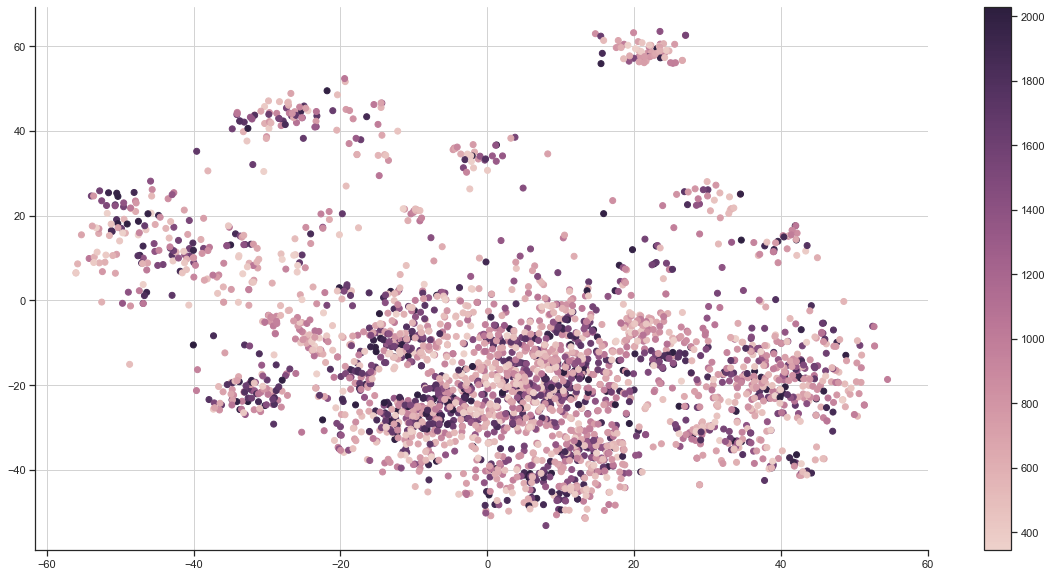

In [160]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(20, 10))
ind = np.where(y["cens"] == 1)[0]
points = ax.scatter(x=X_embedded[ind, 0], y=X_embedded[ind, 1],
                c=y[ind]["time"], cmap=cmap)
f.colorbar(points)

f, ax = plt.subplots(figsize=(20, 10))
ind = np.where(y["cens"] == 0)[0]
points = ax.scatter(x=X_embedded[ind, 0], y=X_embedded[ind, 1],
                c=y[ind]["time"], cmap=cmap)
f.colorbar(points)

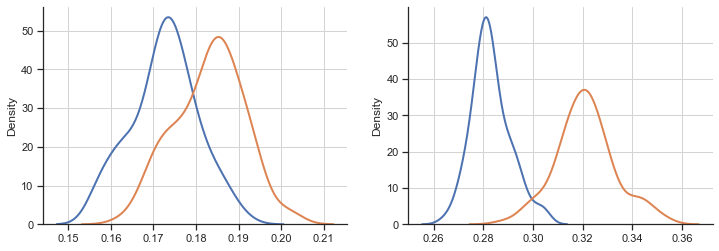

0.1726&0.1831&1.861e-17
0.2831&0.3212&9.812e-63


Text(0, 0.5, '$AUPRC$')

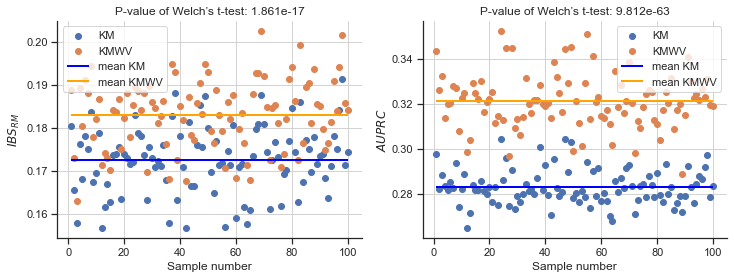

In [115]:
x = np.linspace(1, 100, 100)
ibs_1 = []
ibs_2 = []
auprc_1 = []
auprc_2 = []
np.random.seed(1)

for i, _ in enumerate(x):
    x_sub = df.sample(n=int(X.shape[0]*0.05), replace=True, random_state=i)  #  X.shape[0]*0.05, X.shape[0]*0.3
    time = x_sub["time"].to_numpy()
    cens = x_sub["cens"].to_numpy()
    
    bins_ = cnt.get_bins(time=time)
    y_v = cnt.get_y(cens=cens, time=time)
    
    km = KaplanMeierZeroAfter()
    km.fit(y_v["time"], y_v["cens"])
    sf = km.survival_function_at_times(bins_)

    km1 = KaplanMeierZeroAfterTh(stats.norm)
    km1.fit(y_v["time"], y_v["cens"])
    sf1 = km1.survival_function_at_times(bins_)

    ibs_1.append(metr.ibs_remain(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_))
    ibs_2.append(metr.ibs_remain(y_v, y_v, np.repeat(sf1[np.newaxis, :], y_v.shape[0], axis=0), bins_))

    auprc_1.append(metr.auprc(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_))
    auprc_2.append(metr.auprc(y_v, y_v, np.repeat(sf1[np.newaxis, :], y_v.shape[0], axis=0), bins_))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.kdeplot(ibs_1, ax=axes[0])
sns.kdeplot(ibs_2, ax=axes[0])

sns.kdeplot(auprc_1, ax=axes[1])
sns.kdeplot(auprc_2, ax=axes[1])
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(x, ibs_1, label="KM")
axes[0].scatter(x, ibs_2, label="KMWV")
axes[0].hlines([np.mean(ibs_1)], xmin=min(x), xmax=max(x), color="blue", label="mean KM")
axes[0].hlines([np.mean(ibs_2)], xmin=min(x), xmax=max(x), color="orange", label="mean KMWV")
axes[0].set_title(f"P-value of Welch’s t-test: {stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")
axes[0].legend()
axes[0].set_xlabel("Sample number")
axes[0].set_ylabel(r"$IBS_{RM}$")
print(f"{np.mean(ibs_1):.4f}&{np.mean(ibs_2):.4f}&{stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")

axes[1].scatter(x, auprc_1, label="KM")
axes[1].scatter(x, auprc_2, label="KMWV")
axes[1].hlines([np.mean(auprc_1)], xmin=min(x), xmax=max(x), color="blue", label="mean KM")
axes[1].hlines([np.mean(auprc_2)], xmin=min(x), xmax=max(x), color="orange", label="mean KMWV")
axes[1].set_title(f"P-value of Welch’s t-test: {stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")
print(f"{np.mean(auprc_1):.4f}&{np.mean(auprc_2):.4f}&{stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")
axes[1].legend()

axes[1].set_xlabel("Sample number")
axes[1].set_ylabel(r"$AUPRC$")

In [184]:
from survivors.tree import CRAID

def split_by_tree(X, y, categ=[]):
    p = {'balance': None, 'categ': categ, 'criterion': 'peto', 'cut': False, 'depth': 5, 
         'leaf_model': 'base', 'min_samples_leaf': 0.02, 'signif': 0.05, 'woe': True}

    tree = CRAID(**p)
    tree.fit(X, y)
    return tree.predict(X, target="numb")
    

def print_metric_by_nonparam(df, subsample=0.3, prefix="", tree=False, categ=[]):
    ibs_1 = []
    ibs_2 = []
    auprc_1 = []
    auprc_2 = []
    np.random.seed(1)
    
    d = {}
    for i, _ in enumerate(np.linspace(1, 100, 10)):
        x_sub = df.sample(n=int(df.shape[0]*subsample), replace=True, random_state=i)  #  X.shape[0]*0.05, X.shape[0]*0.3
        time = x_sub["time"].to_numpy()
        cens = x_sub["cens"].to_numpy()

        bins_ = cnt.get_bins(time=time)
        y_src = cnt.get_y(cens=cens, time=time)
        
        strats = [y_src]
        
#         if tree:
#             X_ = x_sub[[c for c in x_sub.columns if not(c in ["time", "cens"])]]
#             nodes = split_by_tree(X_, y_src, categ=categ)
#             strats = [y_src[np.where(nodes == n)[0]] for n in set(nodes)]
#         print(len(strats))
        for y_v in strats:
            for th in ["", 2, 4, 6, stats.norm, stats.gamma, stats.laplace, stats.laplace_asymmetric, stats.rayleigh]:
                if th == "":
                    suff = "km"
                    km = KaplanMeierZeroAfter()
                elif isinstance(th, int):
                    suff = f"Emp({th})"
                    km = KaplanMeierZeroAfterEmp(th)
                else:
                    suff = th._ctor_param["name"]
                    km = KaplanMeierZeroAfterTh(th)
                km.fit(y_v["time"], y_v["cens"])
                sf = km.survival_function_at_times(bins_)

                ibs_ = metr.ibs_remain(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_)
                auprc_ = metr.auprc(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_)
                if suff+"IBS" in d:
                    d[suff+"IBS"].append(ibs_)
                else:
                    d[suff+"IBS"] = [ibs_]
                if suff+"AUPRC" in d:
                    d[suff+"AUPRC"].append(auprc_)
                else:
                    d[suff+"AUPRC"] = [auprc_]
    
    d_ = {k: np.mean(v) for k, v in d.items()}
    d_["dataset"] = prefix
    d_["subsample"] = subsample
    return d_

#     print(f"{prefix + '|'}IBS:({subsample}): {np.mean(ibs_1):.4f}&{np.mean(ibs_2):.4f}&{stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")
#     print(f"{prefix + '|'}AUPRC({subsample}): {np.mean(auprc_1):.4f}&{np.mean(auprc_2):.4f}&{stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")

In [ ]:
from survivors.datasets import DATASETS_LOAD

l = []
for ds_name in ["GBSG", "PBC", "WUHAN", "rott2", "smarto", "support2"]:
    X, y, features, categ, sch_nan = DATASETS_LOAD[ds_name]()
    bins_HO = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])

    df = X.copy()
    df["time"] = y["time"]
    df["cens"] = y["cens"]
    
    d = print_metric_by_nonparam(df, subsample=0.7, prefix=ds_name, tree=True)
    print(d)
    l.append(d)
#     d = print_metric_by_nonparam(df, subsample=0.3, prefix=ds_name)
#     print(d)
#     l.append(d)
#     d = print_metric_by_nonparam(df, subsample=0.05, prefix=ds_name)
#     print(d)
#     l.append(d)
    
df_res = pd.DataFrame(l).T

{'kmIBS': 0.18272659506457498, 'kmAUPRC': 0.5916596587778473, 'Emp(2)IBS': 0.15983086037385646, 'Emp(2)AUPRC': 0.6862837185568077, 'Emp(4)IBS': 0.16616370091003868, 'Emp(4)AUPRC': 0.6966551365936613, 'Emp(6)IBS': 0.17327928299044143, 'Emp(6)AUPRC': 0.6987391157687265, 'normIBS': 0.16667840747234158, 'normAUPRC': 0.6773953288878718, 'gammaIBS': 0.16049073164026723, 'gammaAUPRC': 0.665534479358801, 'laplaceIBS': 0.16166845511592134, 'laplaceAUPRC': 0.6747477573704932, 'laplace_asymmetricIBS': 0.15744830788554384, 'laplace_asymmetricAUPRC': 0.6584376312769913, 'rayleighIBS': 0.1620950675628814, 'rayleighAUPRC': 0.6683777693473474, 'dataset': 'GBSG', 'subsample': 0.7}


In [169]:
# IBS growth
1 - df_res.iloc[:-2:2] / df_res.iloc[[0]].values

,0,1,2,3,4,5,6,7,8,9,10,11
kmIBS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Emp(2)IBS,0.119328,0.077494,0.124112,0.097057,0.194496,0.102633,0.223431,0.186551,0.237919,0.215852,-0.003462,-0.005012
Emp(4)IBS,0.086769,0.041978,0.102731,0.074187,0.179363,0.075502,0.207629,0.169468,0.300756,0.279692,-0.079449,-0.081131
Emp(6)IBS,0.04816,0.001662,0.069344,0.034075,0.152346,0.038578,0.181052,0.140949,0.257029,0.231759,-0.124551,-0.126573
normIBS,0.139883,0.061006,0.157814,0.061726,0.214313,0.023279,0.260495,0.217974,0.231204,0.224371,-0.037639,-0.0409
gammaIBS,0.147812,0.025647,0.147846,-0.012518,0.173898,-0.082069,0.242846,0.208142,0.18937,0.195877,0.01471,0.014153
laplaceIBS,0.119673,0.057262,0.155112,0.081086,0.215621,0.046485,0.236378,0.19606,0.209082,0.20375,-0.047177,-0.049736
laplace_asymmetricIBS,0.145182,0.078021,0.15617,0.083598,0.22333,0.052298,0.226627,0.202478,0.188858,0.190854,-0.032038,-0.034291
rayleighIBS,0.142574,0.069891,0.162653,0.076058,0.223807,0.041114,0.257768,0.216757,0.221492,0.21532,-0.033018,-0.03595


In [170]:
# AUPRC growth
df_res.iloc[1:-2:2] / df_res.iloc[[1]].values - 1

,0,1,2,3,4,5,6,7,8,9,10,11
kmAUPRC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Emp(2)AUPRC,0.159954,0.152555,0.155857,0.120078,0.127571,0.135808,0.164243,0.177948,0.049552,0.041594,0.206808,0.201408
Emp(4)AUPRC,0.177952,0.182824,0.177332,0.15608,0.153136,0.173497,0.181957,0.197517,0.048429,0.045789,0.242865,0.235733
Emp(6)AUPRC,0.181299,0.186243,0.181062,0.159595,0.159156,0.17915,0.186554,0.201956,0.044248,0.041438,0.253551,0.245697
normAUPRC,0.097643,0.108529,0.100925,0.081543,0.089725,0.090939,0.077007,0.096098,0.035642,0.030616,0.168939,0.162325
gammaAUPRC,0.065166,0.034515,0.003209,-0.037374,-0.064939,-0.045506,0.03065,0.045255,-0.001829,-0.008741,-0.003665,-0.007784
laplaceAUPRC,0.066455,0.086445,0.065463,0.06259,0.038338,0.062415,0.04529,0.065347,0.025929,0.021451,0.04639,0.042493
laplace_asymmetricAUPRC,0.061635,0.086961,0.036686,0.057773,0.012918,0.057915,0.017371,0.042432,0.008482,0.014194,0.047027,0.0429
rayleighAUPRC,0.087931,0.09687,0.082256,0.065712,0.073915,0.078757,0.058923,0.077735,0.029598,0.025113,0.146463,0.14016
